In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import cv2
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
import zipfile
import warnings
warnings.filterwarnings("ignore")

In [2]:
!kaggle datasets download -d tharakan684/urecamain

Dataset URL: https://www.kaggle.com/datasets/tharakan684/urecamain
License(s): copyright-authors
 98% 95.0M/96.8M [00:03<00:00, 37.9MB/s]
100% 96.8M/96.8M [00:03<00:00, 25.7MB/s]


In [3]:
zip_ref = zipfile.ZipFile('/content/urecamain.zip')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
train_data = '/content/Train'
validation_data = '/content/Vali'
test_data = '/content/Test'

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_data,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_data,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 6003 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [6]:
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model_resnet50 = Sequential([
    resnet50_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

optimizer_resnet50 = Adam(learning_rate=0.0001)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [7]:
loss_function = 'binary_crossentropy'
metrics = ['accuracy']
model_resnet50.compile(optimizer=optimizer_resnet50, loss=loss_function, metrics=metrics)
history = model_resnet50.fit(train_generator, epochs=25, validation_data=validation_generator)

Epoch 1/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 209s 724ms/step - accuracy: 0.8974 - loss: 0.2664 - val_accuracy: 0.4995 - val_loss: 2.2930
Epoch 2/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 127s 521ms/step - accuracy: 0.9855 - loss: 0.0428 - val_accuracy: 0.5000 - val_loss: 1.4226
Epoch 3/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 142s 521ms/step - accuracy: 0.9896 - loss: 0.0317 - val_accuracy: 0.5940 - val_loss: 0.9515
Epoch 4/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 146s 541ms/step - accuracy: 0.9919 - loss: 0.0275 - val_accuracy: 0.7400 - val_loss: 0.9763
Epoch 5/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 143s 547ms/step - accuracy: 0.9879 - loss: 0.0298 - val_accuracy: 0.9600 - val_loss: 0.0941
Epoch 6/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 100s 518ms/step - accuracy: 0.9942 - loss: 0.0200 - val_accuracy: 0.9490 - val_loss: 0.1541
Epoch 7/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 142s 519ms/step - accuracy: 0.9914 - loss: 0.0259 - val_accuracy: 0.9850 - val_loss: 0.0510
Epoch 8/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 99s 511ms/step - accuracy: 0.9924 - 

In [ ]:
model_resnet50.save("resnet50_model.keras")

In [9]:
validation_generator.reset()
predictions = model_resnet50.predict(validation_generator)
predicted_classes = (predictions > 0.5).astype(int).flatten()
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())
accuracy = accuracy_score(true_classes, predicted_classes)
print(f'The accuracy of the model is: {accuracy:.4f}')
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step
The accuracy of the model is: 0.4970
              precision    recall  f1-score   support

        Fire       0.50      0.51      0.50      1000
    Non-Fire       0.50      0.49      0.49      1000

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.50      0.50      0.50      2000



In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

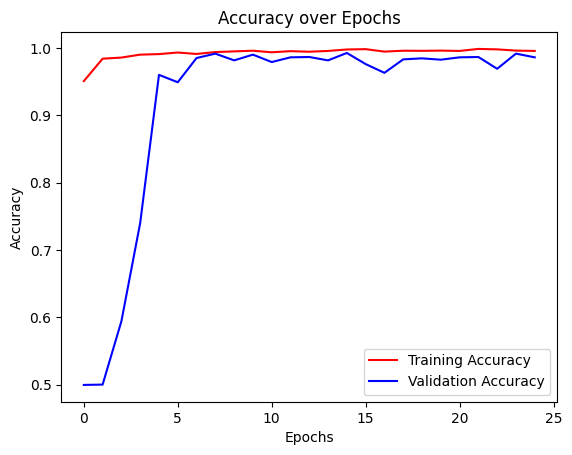

In [11]:
plt.plot(epochs_range, acc, label='Training Accuracy', color='red')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='blue')
plt.legend(loc=0)
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

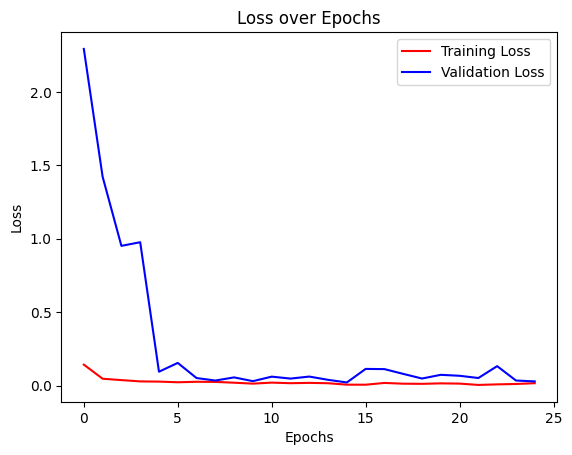

In [12]:
plt.plot(epochs_range, loss, label='Training Loss', color='red')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='blue')
plt.legend(loc=0)
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [17]:
def predict_fire(image_path, model):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    confidence = prediction[0][0]

    if confidence < 0.5:
        label = "Fire"
        confidence_score = (1 - confidence) * 100
    else:
        label = "No Fire"
        confidence_score = confidence * 100

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {label}\nConfidence: {confidence_score:.2f}%", fontsize=14, color='black')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


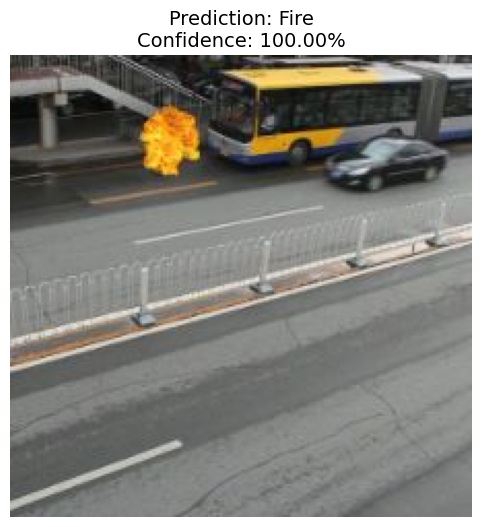

In [18]:
image_path = '/content/Train/Fire/SynDay1222.jpg'
predict_fire(image_path, model_resnet50)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


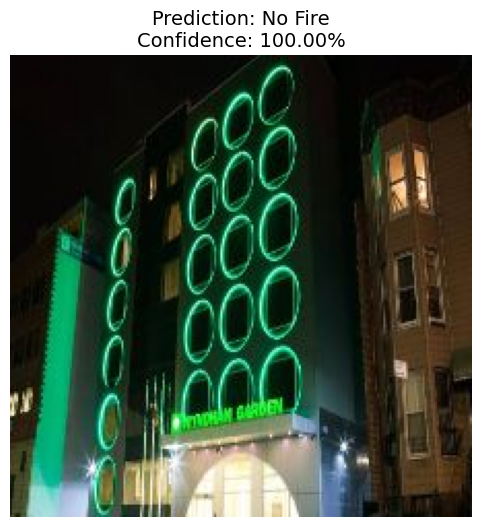

In [19]:
image_path = '/content/Train/Non-Fire/builds100.jpg'
predict_fire(image_path, model_resnet50)